# Analysis for Trapnell's 271 primary human myoblasts

Aftering obtaining a transcript compatibility count (TCC) distribution matrix by running the pipeline, we use the matrix to:

1. <a href='#section1'> Cluster cells via affinity propagation </a>
2. <a href='#section2'> Show the distribution of time spent in low-serum medium for each cluster </a>
3. <a href='#section3'> Generate minimum weight spanning trees with pie-charts as nodes </a>
4. <a href='#section4'> Analyze the expression level of genes using bar plots and diffusion maps </a>
5. <a href='#section5'> Take a closer look a cell T48_CT_G10, a potential misclassifiation </a>

We will show how we accomplish each of these below.

## Running the pipeline and inputting the data matrices

Enter the input paths and the number of processes to be used.

In [52]:
# Directory with SRA files
SRA_dir='/data/SS_RNA_seq/Trapnell/SRA_test/'

# Path to our version of kallisto that outputs transcript compatibility counts
modified_kallisto_path='/data/SS_RNA_seq/Code/kalliPso_pair'

# Path to transcriptome
transcriptome_path='/data/SS_RNA_seq/Trapnell/reference_transcriptome/Homo_sapiens.GRCh38.rel79.cdna.all.fa'

num_processes=32

First run the pipeline, which may take a few hours. Starting with all the SRA files, the pipeline generates the transcript compatibility count matrix using kallisto and then computes distance matrix. Both the compabitibility matrix X and distance matrix D are saved using the Python Pickle module.

In [54]:
import os
cmd=('python Trapnell_wrapper.py -i '+SRA_dir+' -n ' 
     + str(num_processes)+' -k '+modified_kallisto_path
     +' -t '+transcriptome_path)
os.system(cmd)

For the following analysis, we load in the obtained TCC distribution matrix (271-by-1101805 matrix), distance matrix (271-by-271 matrix), and set of labels from the authors (271-by-1 vector).

In [5]:
import pickle
import numpy as np
with open('./Trapnell_TCC_distribution.dat', 'rb') as infile:
    X = pickle.load(infile)
with open('./Trapnell_TCC_pairwise_distance.dat','rb') as infile:
    D = pickle.load(infile)
Trap_labels=np.loadtxt('./Trapnells_data/Trapnell_labels.txt',dtype=str)

## Clustering <a id='section1'></a>

Two different affinity propagation based clusterings to give rise to 3 and 7 clusters

In [14]:
# Clustering is done using scikit-learn's implementation of affinity propagation

# D is a symmetric N-by-N distance matrix where N is the number of cells
from sklearn import cluster
def AffinityProp(D,pref,damp):
    aff= cluster.AffinityPropagation(affinity='precomputed',preference=pref,damping=damp, verbose=True)
    labels=aff.fit_predict(D)
    return labels

# Jensen-shannon metric used to compute distances. 
# This code is used in get_pairwise_distances.py and is repeated here for convenience. 
from scipy.stats import entropy
def jensen_shannon(p, q):
    m=0.5*p+0.5*q
    p = np.transpose(p[p > 0])
    q = np.transpose(q[q > 0])
    m = np.transpose(m[m > 0])
    return np.sqrt(entropy(m)-0.5*entropy(q)-0.5*entropy(p))

from sklearn.metrics.pairwise import pairwise_distances

To generate the 3 clusters, we run affinity propagation.

In [15]:
pref = -1.3*np.ones(271)
labels3=AffinityProp(-D,pref,0.95)

Converged after 73 iterations.


To generate the 7 clusters, we first run affinity propagation to give us 8 clusters. Then, each cluster with less than 5 cells is merged with its closest cluster.

In [16]:
# Clustering
pref = -.6*np.ones(271)
labels8=AffinityProp(-D,pref,0.95)

# First find the clusters with less than 5 cells
from collections import Counter
num_cells_in_cluster=Counter(labels8)
clusters_to_collapse=[x for x in np.unique(labels8) if num_cells_in_cluster[x] < 5]

# For each of those clusters, find the cluster it should be merged with
X_separated=[]
for labl in np.unique(labels8):
    features=X.todense()[np.ix_(np.flatnonzero(labels8==labl),xrange(X.shape[1]))]
    X_separated.append(features)
Xcentroid=np.zeros((len(np.unique(labels8)), (X_separated[0].shape)[1]))
for labl in np.unique(labels8):
    Xq=np.sum(X_separated[labl],axis=0)/float((X_separated[labl].shape)[0])
    Xcentroid[labl, :]=Xq
Dcentroid = pairwise_distances(Xcentroid,metric=jensen_shannon)
cluster_to_collapse_into=[np.argsort(Dcentroid[clusters_to_collapse[0],:])[1]]

# Finally, merge the clusters
labels7=np.array(labels8)
labels7[labels8==clusters_to_collapse[0]]=cluster_to_collapse_into[0]
labels7[labels8>clusters_to_collapse[0]]-=1

Converged after 62 iterations.


## Distribution of the 3 TCC clusters for each cell collection time <a id='section2'></a>

Using the authors' labels, we note that cells 0-68, 69-142, 143-212, and 213-270 were in low-serum medium for 0 hours, 24 hours, 48 hours, and 72 hours before collection, respectively.

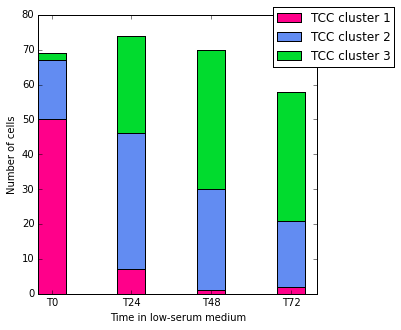

In [194]:
%matplotlib inline

import matplotlib.pyplot as plt

Tr0 = Counter(labels3[:69])
Tr24 = Counter(labels3[69:143])
Tr48 = Counter(labels3[143:213])
Tr72 = Counter(labels3[213:])

ind=np.arange(4)
width = 0.35

Cr0=np.array([Tr0[0], Tr24[0], Tr48[0], Tr72[0]])
Cr1=np.array([Tr0[1], Tr24[1], Tr48[1], Tr72[1]])
Cr2=np.array([Tr0[2], Tr24[2], Tr48[2], Tr72[2]])

plt.figure(figsize=(5,5))
p1 = plt.bar(ind, Cr1, width, color="#ff008a")
p3 = plt.bar(ind, Cr0, width, color="#628cf2",bottom=Cr1)
p2 = plt.bar(ind, Cr2, width, color="#01db2e",bottom=Cr0+Cr1)

plt.xticks(ind + width/2., ('T0', 'T24', 'T48', 'T72'))
plt.legend((p1[0], p3[0],p2[0]), 
           ('TCC cluster 1', 'TCC cluster 2','TCC cluster 3'),bbox_to_anchor=(1.3, 1.05))
plt.ylabel('Number of cells')
plt.xlabel('Time in low-serum medium')

## Minimum weight spanning tree (MST) <a id='section3'></a>

We create two MSTs, one using the centroids of the clusters and another using all 271 original cells. In both cases, distances were computed between length-1101805 vectors. First, we create an MST through the centroids of the 7 clusters:

/home/govinda/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


(-10000.0, 15000.0, -15000.0, 15000.0)

/home/govinda/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


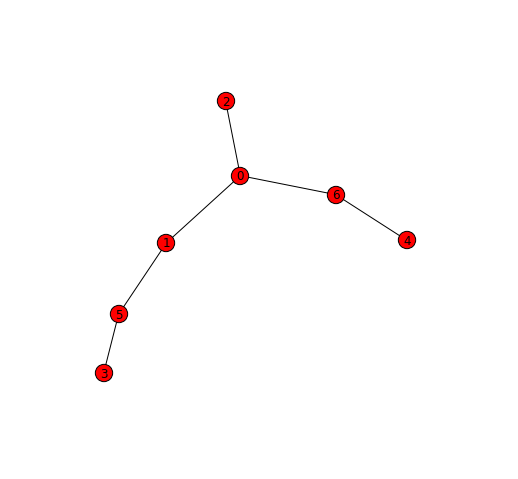

In [142]:
import networkx as nx

X_separated=[]
for labl in np.unique(labels7):
    features=X.todense()[np.ix_(np.flatnonzero(labels7==labl),xrange(X.shape[1]))]
    X_separated.append(features)
    
Xcentroid=np.zeros((len(np.unique(labels7)), (X_separated[0].shape)[1]))
for labl in np.unique(labels7):
    Xq=np.sum(X_separated[labl],axis=0)/float((X_separated[labl].shape)[0])
    Xcentroid[labl, :]=Xq
    
Dcentroid = pairwise_distances(Xcentroid,metric=jensen_shannon)

fig=plt.figure(figsize=(8,8))

G = nx.complete_graph(len(np.unique(labels7)))
for u,v in G.edges():
    G[u][v]["weight"]=Dcentroid[u,v]
    
T=nx.minimum_spanning_tree(G)
pos=nx.spring_layout(T,scale=10000)
nx.draw_networkx(T,pos)
edge_labels=dict([((u,v,),round(d['weight'],2))
             for u,v,d in T.edges(data=True)])

plt.axis('off')

The MST temporally orders the clusters based on differentiation stage. We show the distribution of Trapnell et al.'s cell types in each of the 7 TCC clusters (represented by a node in the MST).

/home/govinda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


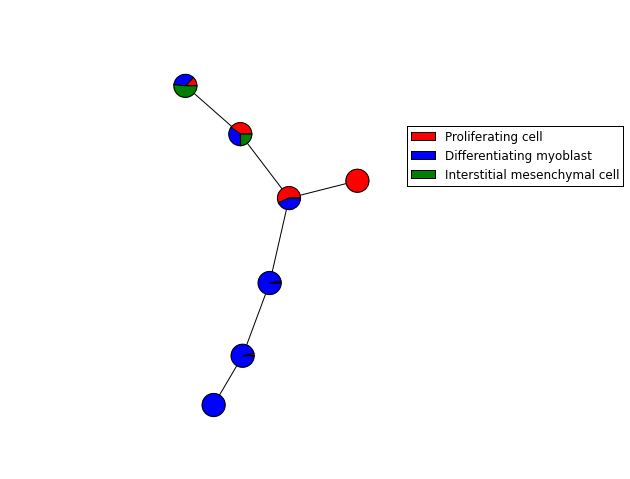

In [143]:
def draw_pie_MST(T,Ltrue,Labels,piesize=0.05,c= ["#628cf2","#ff008a","#01db2e"],
                 Ltrue_unique=['Proliferating cell','Differentiating myoblast',
                               'Interstitial mesenchymal cell'],leg=True,show_clust_names=False):
    pos=nx.spring_layout(T)
    fig=plt.figure(figsize=(8,8))
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(T,pos,ax=ax)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.axis('off')
    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform
    p2=piesize/2.0
    max_p = 0
    for n in T:
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        Ltemp = Ltrue[Labels == n]
        # Save proportion of each label
        fracs = []
        tot_size = float(len(Ltemp))
        for label in np.unique(Ltrue):
            fracs.append(np.sum(Ltemp == label)/tot_size)
        fracs = np.array(fracs)
        # Account for case where pie should only contain one color 
        if np.sum(fracs != 0) == 1: 
            ind = np.where(fracs != 0)[0]
            fracs = [fracs[ind]]
            ctemp = [c[ind]]
        else: 
            ctemp = c
        p,_ = a.pie(fracs,colors=ctemp,shadow=True)
        if len(p) > max_p: 
            patches = p
            max_p = len(p)
        if show_clust_names: plt.title(n)
    if leg: plt.legend(patches, Ltrue_unique, bbox_to_anchor=(14, 1))
    plt.show()

draw_pie_MST(T,Trap_labels,labels7,c=['r','b','g'],leg=True,show_clust_names=False)

We next show the distribution of our three cell types in each of the 7 TCC clusters (represented by a node in the MST). The 3 cell types correspond to the 3 clusters obtained from one of the affinity propagation clusterings above.

/home/govinda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


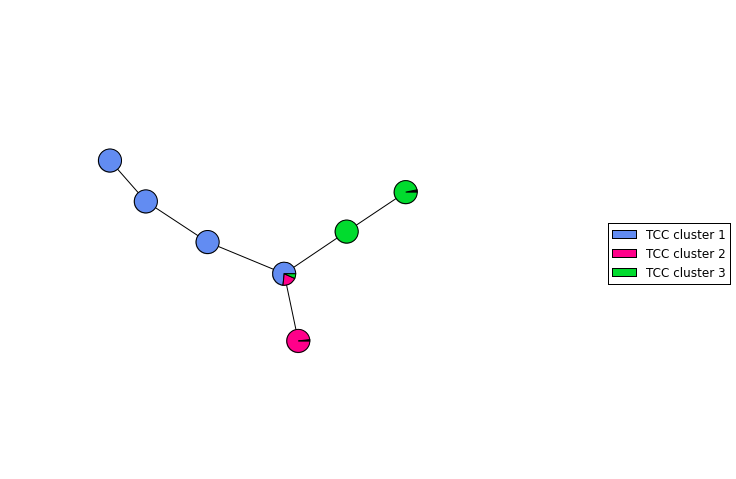

In [144]:
draw_pie_MST(T,labels3,labels7,Ltrue_unique=['TCC cluster 1','TCC cluster 2','TCC cluster 3'],
             leg=True,show_clust_names=False)

Last, we show the MST through all 271 cells, each represented by a length-1101805 vector corresponding to a TCC distribution. We see that the tree does not seem to give interpretable results

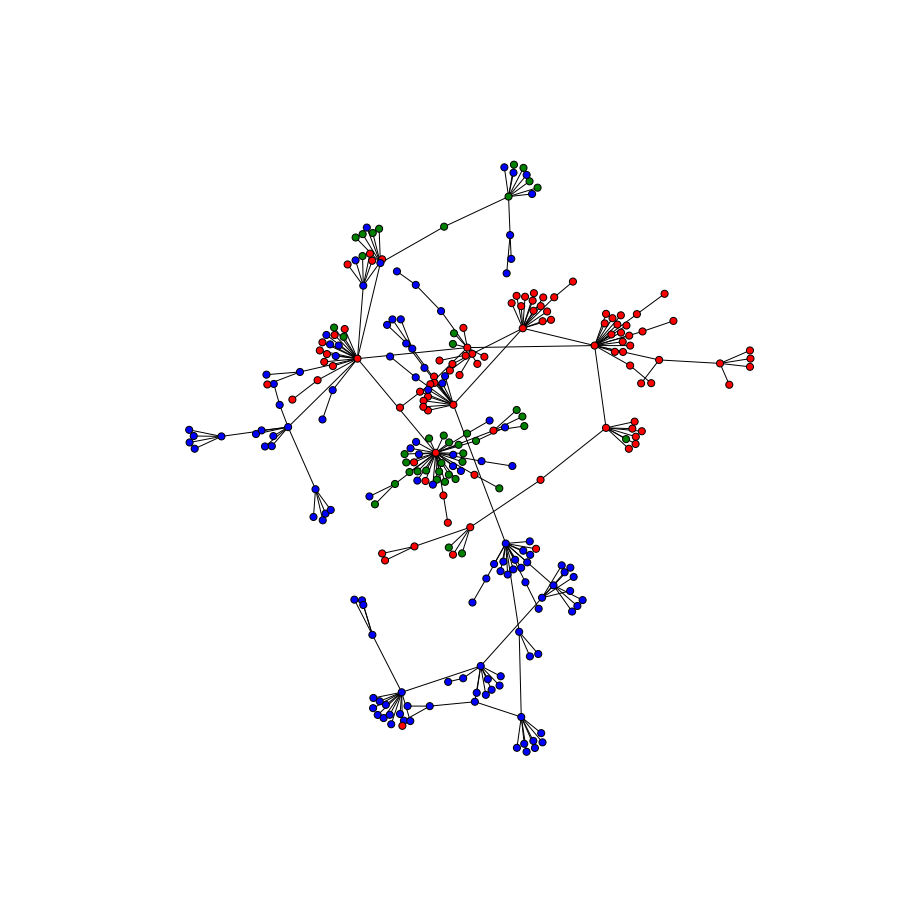

In [143]:
Ghd = nx.complete_graph(271)
for u,v in Ghd.edges():
    Ghd[u][v]["weight"]=D[u,v]
Thd=nx.minimum_spanning_tree(Ghd)
colour={'1': 'red', '2': 'blue', '3':'green'}
vals=map(lambda x: colour[x],Trap_labels )
plt.figure(3,figsize=(12,12)) 
pos=nx.spring_layout(Thd,scale=10)
nx.draw(Thd,node_size=50,node_color=vals,pos=pos)
plt.show()

## Gene expression level analysis <a id='section4'></a>

We thoroughly analyze the gene expressions of the clusters obtained using affinity propagation using the same approach as Trapnell et al. To visualize the TCC distribution matrix, we first perform a dimensionality reduction. Then for each gene of interest, we:

1. Visualize the 271 cells with each data point sized proportionally to the log of the gene expression level
2. Create a bar plot of the percentage of cells in each cluster expressing the gene
3. Create a bar plot visualizing the mean expression of the gene in each cluster

First, we do dimensionality reduction using a diffusion map (takes about 20-30 minutes):

In [24]:
# Dimensionality reduction done using a diffusion map
from diffusion_maps import *
xdm,ydm = plotDiffusionMap(X.todense())

CPU times: user 23min, sys: 8.65 s, total: 23min 9s
Wall time: 23min 6s


Next, we generate the plots. The gene expression vectors we selected here are extracted directly from the columns of Trapnell et al.'s 47192-by-271 [expression matrix](http://bioconductor.org/packages/release/data/experiment/html/HSMMSingleCell.html) and are saved in the 'Trapnells_data' folder.

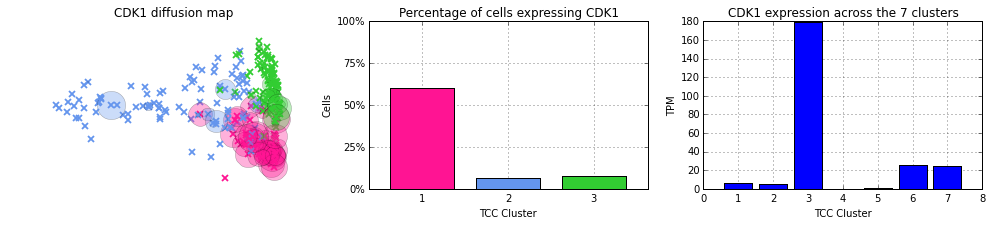

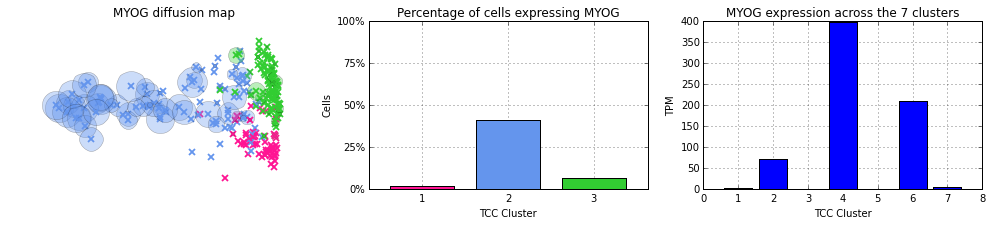

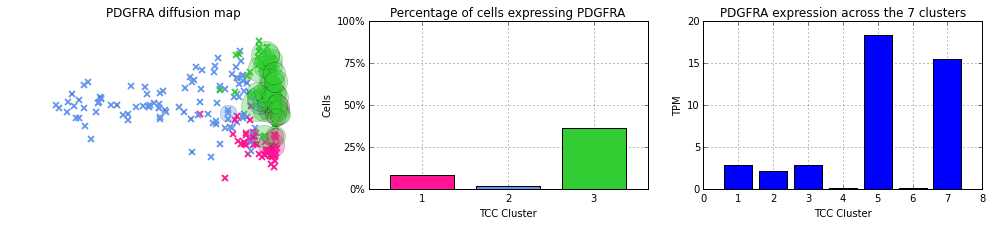

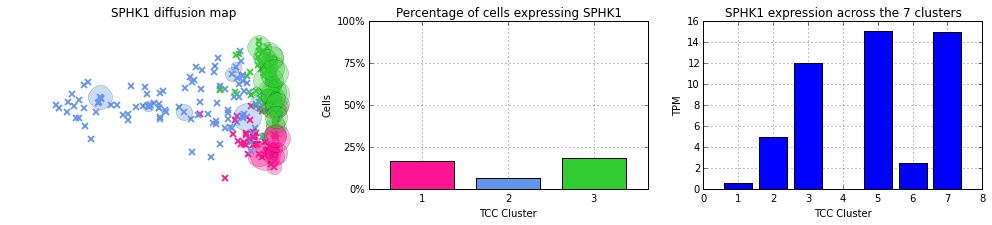

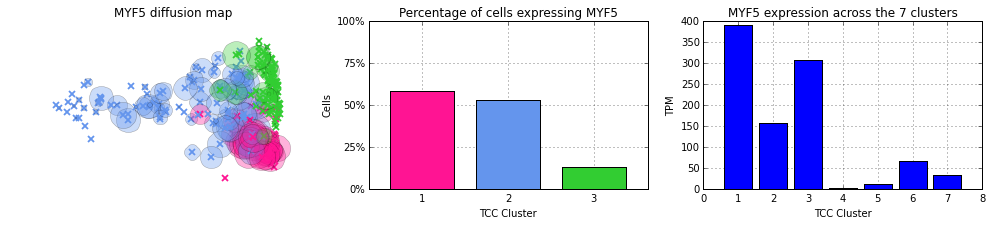

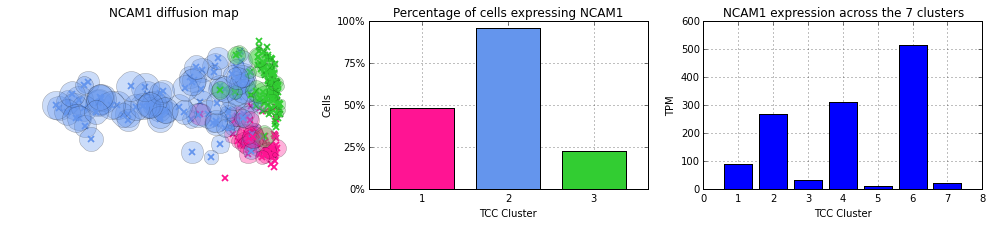

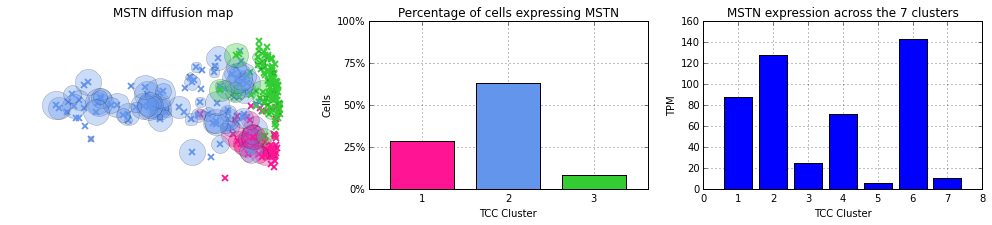

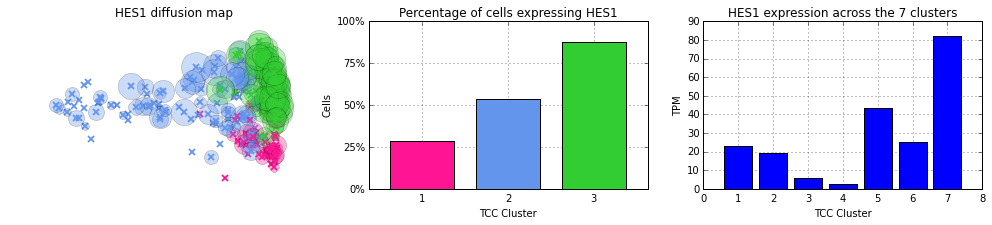

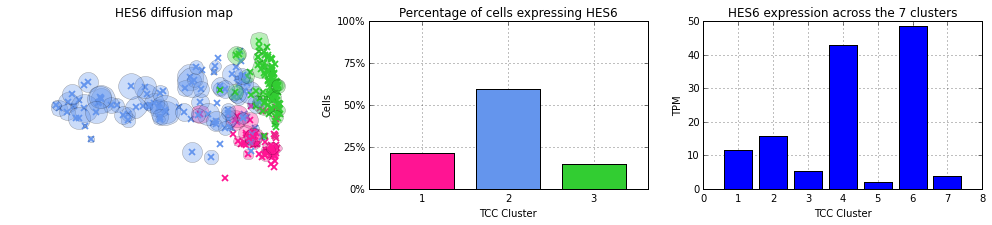

In [138]:
from matplotlib import gridspec

# For a label vector and a gene expression vector (both length-M where M = # cells), 
# compute the proportion of cells in each cluster that expresses the gene. 
def percent_of_each_type(g,labels):
    percents = []
    for label in np.unique(labels):
        v_label = g[np.squeeze(labels==label)]
        v_label_nz = v_label[np.squeeze(v_label>5)]
        percents.append(100*len(v_label_nz)/float(len(v_label)))
    return np.array(percents)

markergenes=["CDK1","MYOG","PDGFRA","SPHK1","MYF5","NCAM1","MSTN","HES1","HES6"]
colors = ['cornflowerblue','deeppink','limegreen']
for gn in markergenes:
    g = np.loadtxt('./Trapnells_data/'+gn+'_TPM.txt')

    fig = plt.figure(figsize=(17,3))
    gs = gridspec.GridSpec(1, 3)

    # Diffusion map with each point sized proportionally to log(expression level)
    ax1 = fig.add_subplot(gs[0])
    vec = np.log(np.ones_like(g) + g)
    vec=30*(vec/max(vec))
    for i in range(271):
        ax1.plot(xdm[i],ydm[i],'x',c=colors[labels3[i]],markersize=6,linewidth=0.0,markeredgewidth=1.8)
        ax1.plot(xdm[i],ydm[i],'o',color=colors[labels3[i]],markersize=vec[i],
                 alpha=0.33,markeredgewidth=0.5,fillstyle='full')
    ax1.set_title(gn+' diffusion map')
    ax1.axis('off')

    # Bar plot of the percentage of cells in each cluster expressing the gene 
    ax2 = fig.add_subplot(gs[1])
    percents = percent_of_each_type(g,labels3)
    percents[0],percents[1] = percents[1],percents[0]
    ind = np.arange(3)
    width = 0.75
    ax2.bar(ind, percents, width,color=['deeppink','cornflowerblue','limegreen'],zorder=3)
    ax2.set_xticks(ind + width)
    ax2.set_xticklabels([1,2,3])
    ax2.set_xticks(ind+width/2)
    ax2.set_xlim(-0.25,3)
    ax2.set_xlabel('TCC Cluster')
    ax2.set_yticks([0,25,50,75,100])
    ax2.set_yticklabels([i for i in ['0%','25%','50%','75%','100%']])
    ax2.set_ylabel('Cells')
    ax2.set_title('Percentage of cells expressing '+gn)
    ax2.grid()
    
    # Bar plot visualizing the mean expression of a gene in each cluster
    ax3 = fig.add_subplot(gs[2])
    g7 = [np.average(g[labels7==i]) for i in np.unique(labels7)]
    ax3.bar(range(1,8),g7,zorder=3,align='center')
    ax3.set_xlabel('TCC Cluster')
    ax3.set_ylabel('TPM')
    ax3.set_title(gn+' expression across the 7 clusters')
    ax3.grid()


## Analysis of cell T48_CT_G10 <a id='section5'></a>

If we relabel the diffusion map obtained above using Trapnell et al.'s labels rather than our own, we notice that one cell (labeled red and located at the far left) seems to be mislabeled:

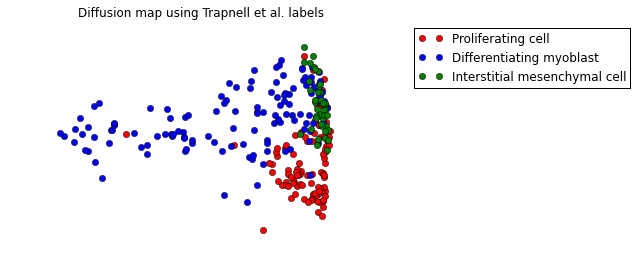

In [131]:
%matplotlib inline
labelsT = Trap_labels.astype(int)-1
colors = ['red','blue','green']
plt.figure()
for i in np.unique(labelsT): 
    plt.plot(xdm[labelsT==i],ydm[labelsT==i],'o',c=colors[i])
plt.title('Diffusion map using Trapnell et al. labels')
plt.legend(['Proliferating cell','Differentiating myoblast','Interstitial mesenchymal cell'], 
           bbox_to_anchor=(1.8, 1))
plt.axis('off')
plt.show()

Taking a closer look at the differentiating genes for both proliferating cells and differentiating myoblasts, we see that in the case of T48_CT_G10, 8 out of the 12 genes show expressions similar to what one would expect from a differentiating myoblast. At the very least, T48_CT_G10 does not appear to be a proliferating cell. 

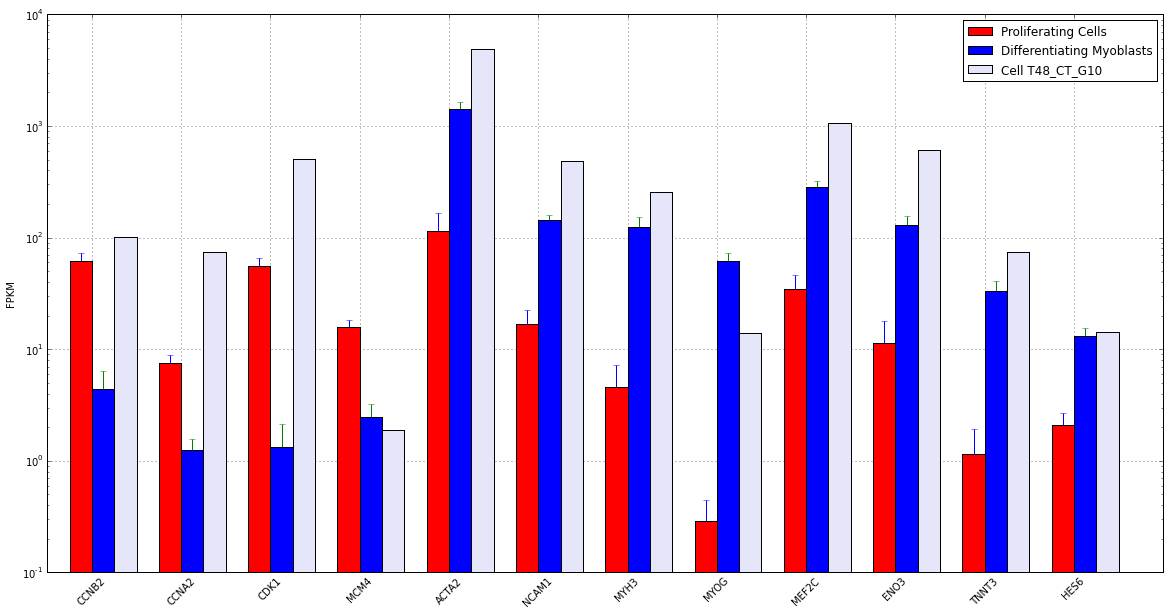

In [171]:
markergenes=["CCNB2","CCNA2","CDK1","MCM4","ACTA2","NCAM1","MYH3","MYOG","MEF2C","ENO3","TNNT3","HES6"]

# Compute means and standard deviations for proliferating cells and differentiating myoblasts
T48_CT_G10,red_mean,blu_mean,red_sd,blu_sd = [],[],[],[],[]
for gn in markergenes:
    g = np.loadtxt('./Trapnells_data/'+gn+'_FPKM.txt') 
    red_mean.append(np.mean(g[Trap_labels=='1']))
    blu_mean.append(np.mean(g[Trap_labels=='2']))
    red_sd.append(np.std(g[Trap_labels=='1'])/np.sqrt(np.sum(Trap_labels=='1')))
    blu_sd.append(np.std(g[Trap_labels=='2'])/np.sqrt(np.sum(Trap_labels=='2')))
    T48_CT_G10.append(g[210])

# Plot the mean expressions of all genes of interest along with the corresponding expressions in T48_CT_G10
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ind = np.arange(len(markergenes))
width = 0.25                    
rects1 = ax.bar(ind,red_mean,width,yerr=red_sd,color='red',zorder=3)
rects2 = ax.bar(ind+width,blu_mean,width,yerr=blu_sd,color='blue',zorder=3)
rects3 = ax.bar(ind+2*width,T48_CT_G10,width,color='lavender',zorder=3)
ax.set_xlim(-width,len(ind)+width)
xTickMarks = [i for i in genes_of_interest]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45)
ax.set_yscale('log')
ax.set_ylabel('FPKM')
plt.legend( (rects1[0], rects2[0], rects3[0]), ('Proliferating Cells', 'Differentiating Myoblasts',"Cell T48_CT_G10"))
ax.grid(zorder=0)
plt.show()